In [20]:
from imblearn.over_sampling import SMOTE
import numpy as np
import matplotlib.pyplot as plt
import cesium.featurize as featurize
from collections import Counter, OrderedDict
from operator import itemgetter
import seaborn as sns
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn.linear_model import LogisticRegressionCV
pd.options.mode.use_inf_as_na = True

In [8]:
#read in our training features:
df = pd.read_csv('trainingfeats.csv')
display(df.shape)
df.head(1)

(7848, 48)

,object_id,mean_u,median_u,std_u,max_u,min_u,mean_g,median_g,std_g,max_g,...,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,-3.254554,-385.699911,-134.146566,-121.103501,-55.954592,-47.449847,-10.015225,-488.057968,-265.686005,...,-61.943836,320.79653,-51.753706,1,0.0,0.0,0.0,NaN,0.017,92


In [15]:
#Filter to only galactic objects, which is the goal of this model
#per the code book, galactic objects have hostgal_specz == 0
egalmask = df['hostgal_specz'] != 0
gal = df[~egalmask]
display(gal.shape)
#let's see our class imbalance
gal.groupby('target').agg('count')

(2325, 48)

,object_id,mean_u,median_u,std_u,max_u,min_u,mean_g,median_g,std_g,max_g,...,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv
target,,,,,,,,,,,,,,,,,,,,,
6,151,151,151,151,151,151,151,151,151,151,...,151,151,151,151,151,151,151,151,0,151
16,924,924,924,924,924,924,924,924,924,924,...,924,924,924,924,924,924,924,924,0,924
53,30,30,30,30,30,30,30,30,30,30,...,30,30,30,30,30,30,30,30,0,30
65,981,981,981,981,981,981,981,981,981,981,...,981,981,981,981,981,981,981,981,0,981
92,239,239,239,239,239,239,239,239,239,239,...,239,239,239,239,239,239,239,239,0,239


In [16]:
#Our classes are imbalanced and we'll need to Create SMOTE object
sm = SMOTE(sampling_strategy='not majority')

#Drop cols I don't want to generate with SMOTE. 
#Things like position in the sky or object_Id are meaningless to simulate with SMOTE
Y = gal['target']
#remove 'target' if using test data, remove distmod if extragalactic (maybe?)
X = gal.drop(['object_id','target', 'ra', 'decl', 'gal_l', 'gal_b', 'ddf', 'distmod'], axis=1) 

display(X.shape)
Y.shape

(2325, 40)

(2325,)

In [17]:
#confirm no nans
X.isnull().sum(axis=0).sum()


0

In [18]:
#Create extra samples and check how many were created
X_new, Y_new = sm.fit_resample(X,Y)
display(X_new.shape)

(4905, 40)

In [19]:
#Re-add target and confirm balance
df = pd.DataFrame(X_new, columns=X.columns)
df['target'] = Y_new
df.groupby('target').agg('count')

,mean_u,median_u,std_u,max_u,min_u,mean_g,median_g,std_g,max_g,min_g,...,errstd_u,errstd_g,errstd_r,errstd_i,errstd_z,errstd_Y,hostgal_specz,hostgal_photoz,hostgal_photoz_err,mwebv
target,,,,,,,,,,,,,,,,,,,,,
6,981,981,981,981,981,981,981,981,981,981,...,981,981,981,981,981,981,981,981,981,981
16,981,981,981,981,981,981,981,981,981,981,...,981,981,981,981,981,981,981,981,981,981
53,981,981,981,981,981,981,981,981,981,981,...,981,981,981,981,981,981,981,981,981,981
65,981,981,981,981,981,981,981,981,981,981,...,981,981,981,981,981,981,981,981,981,981
92,981,981,981,981,981,981,981,981,981,981,...,981,981,981,981,981,981,981,981,981,981


# Lasso Regression for feature selection

In [27]:
lasso = LogisticRegressionCV(penalty='l1', Cs=1, cv=10, solver='liblinear', multi_class='auto', max_iter=200)
X = df.drop('target', axis=1)
Y = df['target']
lassfit = lasso.fit(X, Y)
print('\n Percentage accuracy lasso')
print(lassfit.score(X, Y))


 Percentage accuracy lasso
0.783282364933741


In [30]:
#looks like this stores a coefficient for each target class/column combination
print([len(x) for x in lassfit.coef_])

[40, 40, 40, 40, 40]


In [54]:
#These are the features we can drop:
for i,y in enumerate(X.columns):
    if sum([x[i] for x in lassfit.coef_])==0:
        print(y+": ",[x[i] for x in lassfit.coef_])

mean_u:  [0.0, 0.0, 0.0, 0.0, 0.0]
median_u:  [0.0, 0.0, 0.0, 0.0, 0.0]
max_u:  [0.0, 0.0, 0.0, 0.0, 0.0]
median_g:  [0.0, 0.0, 0.0, 0.0, 0.0]
std_r:  [0.0, 0.0, 0.0, 0.0, 0.0]
errstd_u:  [0.0, 0.0, 0.0, 0.0, 0.0]
errstd_g:  [0.0, 0.0, 0.0, 0.0, 0.0]
errstd_r:  [0.0, 0.0, 0.0, 0.0, 0.0]
errstd_i:  [0.0, 0.0, 0.0, 0.0, 0.0]
errstd_z:  [0.0, 0.0, 0.0, 0.0, 0.0]
errstd_Y:  [0.0, 0.0, 0.0, 0.0, 0.0]
hostgal_specz:  [0.0, 0.0, 0.0, 0.0, 0.0]
hostgal_photoz:  [0.0, 0.0, 0.0, 0.0, 0.0]
hostgal_photoz_err:  [0.0, 0.0, 0.0, 0.0, 0.0]
mwebv:  [0.0, 0.0, 0.0, 0.0, 0.0]


In [57]:
#These we should keep:
featnames =[]
for i,y in enumerate(X.columns):
    if sum([x[i] for x in lassfit.coef_])!=0:
        print(y+": ",[x[i] for x in lassfit.coef_])
        featnames.append(y)

std_u:  [0.0, 0.0, 0.0, -0.003877131475511737, 0.0]
min_u:  [-0.0009795026652530008, 0.0, 0.0, 0.0, 0.0017203273422799145]
mean_g:  [-5.805773146444283e-06, 0.0, 0.00017708829076440325, 0.0, 0.002121419152695737]
std_g:  [0.0, 0.002570556470675719, 0.0, 0.0, -0.0014493691643227594]
max_g:  [-0.0018519349207097467, 0.002552204634220459, 0.0, 0.0, -0.0017690346255829176]
min_g:  [-0.0010725910033354373, 0.0015216870924265697, -0.00018457310543393992, 0.0, 0.0]
mean_r:  [0.0, 0.003195247849368238, 0.0, 0.0, 0.0]
median_r:  [-0.003033555070596582, 0.0012299687723499807, 0.0, 0.0, 0.0]
max_r:  [0.0, 0.0, 0.0, 0.0, 0.0015435420682149911]
min_r:  [0.000888303391865921, 0.0, 0.0, 0.0, 0.003477329611429287]
mean_i:  [0.0016551105695399608, 0.0, 0.0, -0.00022147577007441236, 0.00042243376718292596]
median_i:  [0.0, 0.0, 0.0003965152862336658, -0.0014284258408459602, 0.0017340662093049558]
std_i:  [0.0, 0.0, 0.0032523295848495303, 0.0, 0.004351571988087526]
max_i:  [-2.8284097631386146e-05, -3.04

In [78]:
X2.columns

Index(['std_u', 'min_u', 'mean_g', 'std_g', 'max_g', 'min_g', 'mean_r',
       'median_r', 'max_r', 'min_r', 'mean_i', 'median_i', 'std_i', 'max_i',
       'min_i', 'mean_z', 'median_z', 'std_z', 'max_z', 'min_z', 'mean_Y',
       'median_Y', 'std_Y', 'max_Y', 'min_Y'],
      dtype='object')

In [77]:
#Store the feats that are nonzero coefficients:
X2 = X[featnames]
display(X2.shape)
X2.head()

(4905, 25)

,std_u,min_u,mean_g,std_g,max_g,min_g,mean_r,median_r,max_r,min_r,...,mean_z,median_z,std_z,max_z,min_z,mean_Y,median_Y,std_Y,max_Y,min_Y
0,-134.146566,-55.954592,-47.449847,-488.057968,-265.686005,-162.170945,-103.541367,-85.524307,601.787302,455.121346,...,611.984558,445.737061,381.953735,378.188141,-116.913223,-1100.440063,-681.858887,-530.644592,-422.184509,-422.815094
1,0.041636,0.595782,-0.503772,-0.028842,0.160726,0.139306,1.009171,-1.685146,1.694776,1.338557,...,3.025061,3.990337,13.652751,17.768314,-3.818113,-2.582174,-2.793446,-3.693207,-8.176320,-12.695161
2,1.258178,-0.535383,-1.882209,-0.093323,0.139665,0.508403,0.388879,-1.110749,1.554792,6.152494,...,30.658575,4.062335,8.158356,15.606678,-7.061294,-3.843095,-2.316400,-6.478241,-9.012094,-52.764721
3,1.038388,32.965803,7.087901,0.484688,-0.045596,-0.213507,0.140599,-1.573071,6.202717,8.668026,...,63.732166,142.929169,1897.066772,432.418915,-6.794837,-12.490160,-5.809950,-7.007833,-10.981421,-24.442568
4,-6.376560,-2.888251,-0.909857,-0.050638,-2.184235,-1.862304,-0.190685,-0.415116,23.068975,35.239977,...,70.879387,64.997238,46.008011,29.690588,-8.199913,-137.934402,-216.426498,-186.129196,-126.412323,-63.193478


# KNN with lasso-chosen features

In [69]:
#test a KNN

#Create Train/Test splits
galX_train, galX_test, galY_train, galY_test = train_test_split(
    X2, Y, test_size=0.5)



galknn = KNeighborsClassifier(n_neighbors=5, weights='distance')
galknn.fit(galX_train, galY_train)

scores = cross_val_score(galknn,galX_test,galY_test, cv=10)
display(scores)
scores.mean()

array([0.96370968, 0.95528455, 0.94715447, 0.95528455, 0.94693878,
       0.93877551, 0.95102041, 0.95510204, 0.9795082 , 0.95884774])

0.955162592269583

Counter({92: 981, 65: 981, 16: 981, 6: 981, 53: 981})


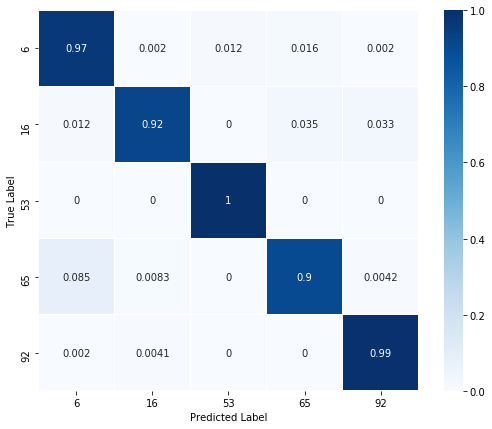

In [75]:
counts = Counter(df['target'])
galLabels, values = zip(*sorted(counts.items(), key=itemgetter(1)))

srt = sorted(galLabels)
galY_pred = galknn.predict(galX_test)
print(counts)
cm = confusion_matrix(galY_test, galY_pred,labels = srt)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
annot = np.around(cm, 2)
fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(cm, yticklabels=srt,xticklabels=srt, cmap='Blues',annot = True, lw=0.5)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_aspect('equal')

# Adding class 99 for unknown objects

In [72]:
#generate probability of all classes for each object.
#Classes will be the column titles:
cols = sorted(Y.unique())

#This df should have a row for each object and a column for each class. 
#the data are class probabilites and each row sums to 1 (100%)
orderprobs = pd.DataFrame(galknn.predict_proba(galX_test), columns=cols)
orderprobs['max_value'] = orderprobs.max(axis=1)
#This variable is the 'unknown' threshold. If no probabilities are over this threshold, 
#the object will get assigned to the unknown class, 99.
thresh = .6

#if an object is getting assigned to class 99, this is the confidence level to give class 99.
#all other classes will be scaled proportionately down from their original values so the row sums to 1 (100%)
confidence99 = .75

orderprobs[99] = np.where(orderprobs.max_value < thresh,confidence99,0)
#Don't need the max value column anymore
orderprobs = orderprobs.drop('max_value', axis=1)

#loop through the columns, scaling down values for rows where class 99 is nonzero.
for col in cols:
    orderprobs[col] = orderprobs[col]*(1-orderprobs[99])

    
print(orderprobs.head(20).sum(axis=1).mean()) #This should be 1.0 if everything worked.
print(orderprobs.head(20).sum(axis=1).std()) #This should be 0.0 if everything worked.

1.0
0.0


In [73]:
#How many objects got class 99?
orderprobs.astype(bool).sum(axis=0)

6     653
16    534
53    520
65    599
92    546
99     79
dtype: int64